In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [75]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.nn.functional as F

In [76]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import torch

class CustomDataset(Dataset):
    def __init__(self, image_paths, label_paths):
        self.image_paths = image_paths
        self.label_paths = label_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load the image
        image = Image.open(self.image_paths[idx])
        np_image = np.array(image, dtype=np.float32)

        # Normalize the image
        normalized_image = np_image / 65535.0  # For 16-bit images

        # Load and process the label data
        label_image = Image.open(self.label_paths[idx])
        label_array = np.array(label_image, dtype=np.float32)

        grayscale_to_class_mapping = {0: 0, 128: 1, 255: 2} # a set that maps gray-levels to a class

        # Map grayscale values to class labels
        mapped_labels = np.copy(label_array)
        for grayscale_value, class_id in grayscale_to_class_mapping.items():
            mapped_labels[label_array == grayscale_value] = class_id

        # Convert to PyTorch tensors
        image_tensor = torch.from_numpy(normalized_image).unsqueeze(0) # unsqueeze to enable channel dimension, was gone due to being a grayscale image
        label_tensor = torch.from_numpy(mapped_labels)

        return image_tensor, label_tensor

In [77]:
### Label images ###
# white class - 255 nickel
# gray class - 128 ysz
# black class - 0 pores
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # -------
        # input: 128x128x1
        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 128x128x128

        # input: 256x256x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 128x128x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 16x16x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 16x16x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x256

        # Decoder
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        # Decoder
        xu2 = self.upconv2(xe32)  # Upsample from xe32
        xu22 = torch.cat([xu2, xe22], dim=1)  # Concatenate with xe22
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)  # Upsample from xd22
        xu33 = torch.cat([xu3, xe12], dim=1)  # Concatenate with xe12
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        # Output layer
        out = self.outconv(xd32)

        return out

In [78]:
from torch.utils.data import DataLoader, random_split
from torch import optim
import os


def get_image_paths(data_dir, label_dir):
    data_paths = [os.path.join(data_dir, img) for img in sorted(os.listdir(data_dir))]
    label_paths = [os.path.join(label_dir, lbl) for lbl in sorted(os.listdir(label_dir))]
    return data_paths, label_paths

data_dir = '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop'
label_dir = '/content/gdrive/Othercomputers/MyMac/training_dataset/label_crop'
image_paths, label_paths = get_image_paths(data_dir, label_dir)
print(image_paths)

# Step 1: Setup Dataset and Dataloader
dataset = CustomDataset(image_paths=image_paths,
                        label_paths=label_paths)

# Split dataset into training and validation
total_size = len(dataset)
train_size = int(0.70 * total_size)  # 70% of the dataset
val_size = int(0.15 * total_size)    # 15% of the dataset
test_size = total_size - train_size - val_size  # Remaining 15%

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)#, num_workers=4, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)#, num_workers=4, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)#, num_workers=4, pin_memory=False)

# Step 2: Model Initialization
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")
model = UNet(n_class=3)
model.to(device)

# Step 3: Loss Function & Optimizer
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Step 4: Training Loop
num_epochs = 20  # ADJUSTABLE
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(images)

        labels = labels.squeeze(1).long() # Fix for dimension mismatch, removes channel dimension and ensure it a longtensor
        loss = criterion(outputs, labels)
        loss.backward()  # backward pass
        optimizer.step()  # optimize

        if batch_idx % 10 == 0:  # print every 10 batches
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss = 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            labels = labels.squeeze(1).long()  # Fix for dimension mismatch
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f"Validation Loss after Epoch {epoch+1}: {val_loss}")

# Save the model after training
torch.save(model.state_dict(), 'xray.pth')
print("Finished Training and saved the model.")


['/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0001.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0002.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0003.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0004.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0005.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0006.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0007.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0008.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0009.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0010.tiff', '/content/gdrive/Othercomputers/MyMac/training_dataset/data_crop/cropped_data_0011.tiff', '/content

In [80]:
# Testing phase
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1) # Turn output to probability map

        # Get the predicted class for each pixel from the output probabilities
        _, predicted = torch.max(probabilities, 1)

        labels = labels.squeeze(1).long()  # Remove the channel dimension from labels if necessary

        loss = criterion(outputs, labels)  # Compute the loss
        test_loss += loss.item()

        # Calculate pixel-wise accuracy
        total += labels.numel()  # Count the total number of pixels in the batch
        correct += (predicted == labels).sum().item()  # Count the total number of correct pixels

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total  # Calculate the percentage of correct pixels
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    dice_score = dice_coefficient(predicted, labels, num_classes=3)
    print(f'Dice Score: {dice_score}')


Test Loss: 0.0335, Test Accuracy: 98.79%
Dice Score: 0.9857442378997803


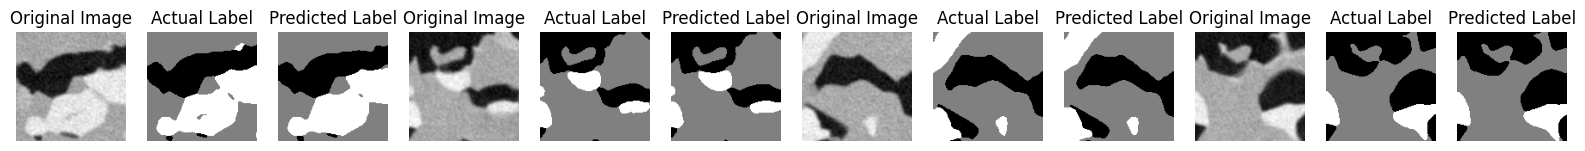

In [81]:
import matplotlib.pyplot as plt

def plot_predictions(images, actuals, predicted):
    plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
    for i in range(len(images)):
        # Rescale the images from [0, 1] to [0, 65535]
        image = images[i].squeeze() * 65535

        # Contrast stretching the original image for visualization (directly doing 16bit to 8bit got fucked)
        vmin, vmax = image.min(), image.max()
        image = (image - vmin) / (vmax - vmin)  # Scale pixel values to 0-1 range
        image = (image * 255).to(torch.uint8).cpu().numpy()  # Scale up to 0-255 range and convert to 8-bit

        # Display the original image
        plt.subplot(1, len(images)*3, i*3+1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Original Image')
        plt.axis('off')

        # Display the actual label image
        actual = actuals[i].squeeze()  # Assuming actuals is a batch of label images
        plt.subplot(1, len(images)*3, i*3+2)
        plt.imshow(actual, cmap='gray')
        plt.title(f'Actual Label')
        plt.axis('off')

        # Display the predicted label image
        pred = predicted[i].squeeze()  # Assuming predicted is a batch of label images
        plt.subplot(1, len(images)*3, i*3+3)
        plt.imshow(pred, cmap='gray')
        plt.title(f'Predicted Label')
        plt.axis('off')

    plt.show()

# Select a few images (e.g., first 4)
selected_images = images[:4].cpu()
actual_labels = labels[:4].cpu()
predicted_labels = predicted[:4].cpu()

# Call the function
plot_predictions(selected_images, actual_labels, predicted_labels)

In [79]:
def dice_coefficient(predicted, target, num_classes):
    dice_scores = []  # To store dice coefficient for each class

    # Convert predictions and targets to one-hot encoded form
    predicted_one_hot = F.one_hot(predicted, num_classes).permute(0, 3, 1, 2).float()
    target_one_hot = F.one_hot(target, num_classes).permute(0, 3, 1, 2).float()

    # Calculate Dice coefficient for each class
    for class_index in range(num_classes):
        intersection = (predicted_one_hot[:, class_index, :, :] * target_one_hot[:, class_index, :, :]).sum()
        union = predicted_one_hot[:, class_index, :, :].sum() + target_one_hot[:, class_index, :, :].sum()
        dice_score = (2 * intersection + 1e-6) / (union + 1e-6)  # Adding a small epsilon to avoid division by zero
        dice_scores.append(dice_score)

    # Average Dice score across all classes
    avg_dice_score = sum(dice_scores) / len(dice_scores)
    return avg_dice_score.item()  # Return the value as a Python scalar